In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
#import cmocean as cmo
#import octant


# some tools to interpolate croco outputs vertically
######################
import sys
sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 
import tools as to


# 1. Make density field

In [40]:
def calc_den(salt,temp):
    '''
    Stratification properties are conservative through 
    a linear equation of state:

       R0 == 1027.0d0                   ! kg/m3
       T0 == 25.0d0                      ! Celsius
       S0 == 35.0d0                     ! PSU
    TCOEF == 1.7d-4                     ! 1/Celsius
    SCOEF == 7.6d-4                     ! 1/PSU
    '''
    return 1027.*(1.+7.6e-4*(salt-35.)-1.7e-4*(temp-25.))

In [41]:
# EOS parameters
R0=1027.0
T0=25.0
S0=35.0
TCOEF=1.7e-4
SCOEF=7.6e-4


# Front parameters
M20_R=1e-6
M2_yo=120e3 
M2_r=5e3

N20=2e-3
N2_zo=65.0
N2_r=5.0


# Grid parameters
theta_s = 0.4
theta_b = 0.4
hc = 5.
Vtransform=1
Vstretching=1
s_rho = 64

grd = netCDF4.Dataset('./croco_grd.nc') 
g = 9.8
y_rho = grd['y_rho'][:,:]
pm = grd['pm'][:,:]
pn = grd['pn'][:,:]
f = grd['f'][0,0]
dy = grd['y_rho'][1,0] - grd['y_rho'][0,0]  # assume constant grid spacing.



#z = octant.depths.get_zrho(Vtransform, Vstretching, s_rho, theta_s, theta_b, grd['h'][:], hc)
#Hz = octant.depths.get_Hz(Vtransform, Vstretching, s_rho, theta_s, theta_b, grd['h'][:], hc)

z = to.zlevsold(grd['h'][:],grd['h'][:]*0.,theta_s,theta_b,hc,s_rho,'r','new2008')
z_w = to.zlevsold(grd['h'][:],grd['h'][:]*0.,theta_s,theta_b,hc,s_rho,'w','new2008')
Hz = z_w[1:,:,:] - z_w[:-1,:,:]; 

# Horizontal stratification is controlled by salinity (only)
M2 = np.ones_like(y_rho)*M20_R
M2[y_rho > M2_yo] = M20_R * np.exp( (M2_yo - y_rho[y_rho > M2_yo]) / M2_r )

s = np.cumsum(M2 * dy / (g * SCOEF), axis=0)
s -= s[-1] - S0
s = s * np.ones((s_rho, 1, 1), 'd')

M2 = M2*np.ones_like(z)


# Vertical stratification is controlled by temperature (only)
N2 = N20 * np.exp((N2_zo + z) / N2_r )
N2[z > -N2_zo] = N20

t = np.zeros_like(s)
for n in range(s_rho):
    t[n] = - np.trapz(N2[n:] / (g * TCOEF), x=z[n:], axis=0)

t = t - np.min(t)

# calculate density
density = calc_den(s, t)

print("Ri ->", np.min(N2*f**2/(M2**2)), np.max(N2*f**2/(M2**2)))
print("Density ->", np.max(density), np.min(density))

Ri -> 9.632700154535291 2.138376314480912e+19
Density -> 1031.364749999786 1003.6043134627004


# 2. Calculate relative vorticity, N2, M2, Ro, and Ri

In [31]:
u_z = M2 * Hz / f
u = np.cumsum(u_z, axis=0)
ubottom = np.zeros((1, u.shape[1], u.shape[2]))
u = np.concatenate( (ubottom, u) )
u = 0.5*(u[1:]+u[:-1])

#dudx, dudy = octant.hgrad(u, z, pm, pn)
zeta = - to.diffeta(u,pn,z,z_w)

#N2 = octant.shrink(N2, np.shape(zeta))
#M2 = octant.shrink(M2, np.shape(zeta))
#z = octant.shrink(z, np.shape(zeta))
#density = octant.shrink(density, np.shape(zeta))

N2 = to.rho2v(N2)
M2 = to.rho2v(M2)
z = to.rho2v(z)
density = to.rho2v(density)


In [33]:
# Reshape
N2 = np.mean(N2[:,:,:], axis=-1)
M2 = np.mean(M2[:,:,:], axis=-1)
zeta = np.mean(zeta[:,:,:], axis=-1)
density = np.mean(density[:,:,:], axis=-1)
z = np.mean(z[:,:,:], axis=-1)
y = 0.5*(y_rho[1:,0]+y_rho[:-1,0])*np.ones_like(z)

Ro_g = zeta/f
Ri_g = N2*(f**2)/(M2**2)

# 3. Make triangulation for interpolation

In [34]:
# triangulation

from matplotlib import tri

ta = tri.Triangulation(y.flatten(), z.flatten())

interp_Ro = tri.LinearTriInterpolator(ta, Ro_g.flatten())
interp_Ri = tri.LinearTriInterpolator(ta, Ri_g.flatten())
interp_N2 = tri.LinearTriInterpolator(ta, N2.flatten())
interp_M2 = tri.LinearTriInterpolator(ta, M2.flatten())
interp_z = tri.LinearTriInterpolator(ta, z.flatten())

# 4. Ray-tracing functions

In [35]:
def ray_tracing_RHS(t,y, pm=1., omega=2*np.pi/86400.):
    
    Roi = interp_Ro(t,y.real[0])
    Rii = interp_Ri(t,y.real[0])
    N2i = interp_N2(t,y.real[0])
    M2i = interp_M2(t,y.real[0])

    omega_min=f*np.sqrt(1+Roi-1./Rii)

    iso_slope=M2i/N2i

    if omega_min<=omega:
        lamda = iso_slope + pm*np.sqrt((omega**2-omega_min**2)/N2i)
    else:
        lamda = np.nan
        
    return lamda

In [36]:
from scipy.integrate import ode

def calc_oneray(x0, z0, pm=1.0, direction='Left'):
    r = ode(ray_tracing_RHS).set_integrator('zvode', method='bdf')
    r.set_initial_value(z0, x0).set_f_params(pm)

    if direction=='Left':
        x1 = 0
        dt = -500.
        xray = []
        zray = []
        while r.successful() and r.t > x1:
            xray.append(r.t+dt)
            zray.append(r.integrate(r.t+dt))
            
    elif direction=='Right':
        x1 = 200e3
        dt = 500.
        xray = []
        zray = []
        while r.successful() and r.t < x1:
            xray.append(r.t+dt)
            zray.append(r.integrate(r.t+dt))       

    xray = np.asarray(xray)
    zray = np.asarray(zray)
    
    return xray, zray

In [37]:
def calc_ray(x0, z0, ref=0, pm=1.0, direction="Left"):
    xray0, zray0 = calc_oneray(x0, z0, pm=pm, direction="Left")
    zray0 = zray0[:,0]

    if ref==0:
        xray = xray0
        zray = zray0
    else:
        for nnn in range(ref):
            if nnn%2==0: 
                direc = "Right"
            else:
                direc = "Left"
            pm=-pm
            x0 = xray0[-2]
            z0 = zray0[-2]
            xray1, zray1 = calc_oneray(x0, z0, pm=pm, direction=direc)
            zray1 = zray1[:,0]

            xray = np.hstack((xray0[:-2], xray1))
            zray = np.hstack((zray0[:-2], zray1))
    
    return xray, zray

# 5. Make plots

/venv/py3-phyocean/lib/python3.6/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
/venv/py3-phyocean/lib/python3.6/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/venv/py3-phyocean/lib/python3.6/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


(-80.0, 0.0)

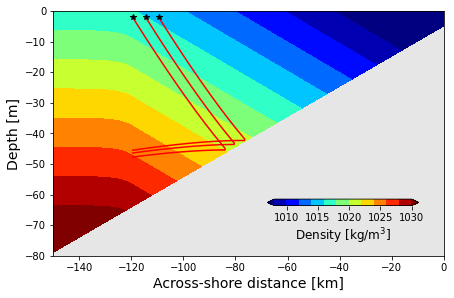

In [38]:
fig = plt.figure(figsize=(7,4.5))

ax2 = fig.add_subplot(1,1,1)

# Conduct ray-tracing and plot rays
for x0 in [119.5e3, 114.5e3, 109.5e3]:
    z0=-2
    xray, zray = calc_ray(x0, z0, ref=1, direction="Left", pm=1.)
    ax2.plot(-xray[(xray>60e3)&(xray<120e3)]/1e3, zray[(xray>60e3)&(xray<120e3)], 'r-')
    ax2.plot(-x0/1e3, z0, 'k*')

    
# Plot background density     
pcm2 = ax2.contourf(-y/1e3, z,  density, \
                    levels=np.arange(1008, 1032,2), cmap='jet',  extend='both')

ax2.set_ylabel('Depth [m]', fontsize=14)
ax2.set_xlabel('Across-shore distance [km]', fontsize=14)
ax2.patch.set_facecolor([0.9,0.9,0.9])

cax = fig.add_axes([0.55, 0.28, 0.3, 0.02])
cb = plt.colorbar(pcm2, cax=cax, 
                  orientation='horizontal', ticks=np.linspace(1010, 1030,5))
cb.set_label('Density [kg/m$^3$]', fontsize=12)


ax2.set_xlim([-150,0])
ax2.set_ylim([-80,0])


# plt.savefig("RT_105f.png", dpi=200)